In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import brainiak.reconstruct.iem

In [2]:
# Generate synthetic data with dimension 9 that is linearly separable
n, dim = 300, 9
n_ = int(n/3)
np.random.seed(0)
C = -.25 + .5*np.random.rand(dim, dim) # covariance matrix
centers_0 = np.linspace(-1, 1, dim)
centers_60 = np.roll(centers_0,5)
centers_120 = centers_0[::-1]
X_ = np.vstack((np.dot(np.random.randn(n_, dim), C) + centers_0,
          np.dot(np.random.randn(n_, dim), C) + centers_60,
          np.dot(np.random.randn(n_, dim), C) + centers_120))
X = X_/np.max((np.max(X_), np.min(X_)))

y = np.hstack((np.zeros(n_), 60*np.ones(n_), 120*np.ones(n_)))

print("Data, X, dimensions: " + str([np.size(X,0), np.size(X,1)]))

Data, X, dimensions: [300, 9]


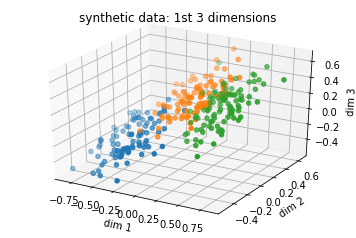

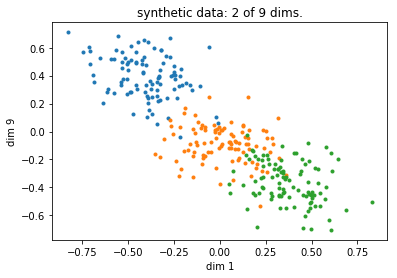

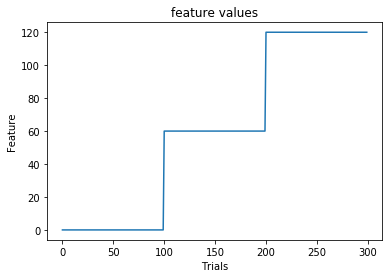

In [3]:
# Plot some perspectives of the synthetic data: 
# 3-D scatter plot and 2-D perspectives 

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[0:(n_-1),0], X[0:(n_-1),2], X[0:(n_-1),2])
ax.scatter(X[n_:(2*n_-1),0], X[n_:(2*n_-1),2], X[n_:(2*n_-1),2])
ax.scatter(X[(2*n_):,0], X[(2*n_):,2], X[(2*n_):,2])
ax.set_xlabel('dim 1')
ax.set_ylabel('dim 2')
ax.set_zlabel('dim 3')
plt.title('synthetic data: 1st 3 dimensions')
plt.show()

plt.figure()
plt.plot(X[0:(n_-1),0], X[0:(n_-1),8],'.',color='C0')
plt.plot(X[n_:(2*n_-1),0], X[n_:(2*n_-1),8],'.',color='C1')
plt.plot(X[(2*n_):,0], X[(2*n_):,8],'.',color='C2')
plt.xlabel('dim 1')
plt.ylabel('dim 9')
plt.title('synthetic data: 2 of 9 dims.')
plt.show()

plt.figure()
plt.plot(y)
plt.xlabel('Trials')
plt.ylabel('Feature')
plt.title('feature values')
plt.show()

Output should be a 3-D view of (3 of) the dimensions of the data. Note that clusters are separable (i.e. you could, roughly, draw in a plane and separate them). A second plot shows just one projects of this, which makes separability more clear. The final plot just shows the feature labels.

In [4]:
# Create IEM object, feed it synthetic data, create new synthetic data
# and predict feature (direction) from that data.

s = brainiak.reconstruct.iem.InvertedEncoding(6, 6, -30, 210)
s.fit(X,y)


/Users/david/anaconda3/envs/brainiak/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


InvertedEncoding(channel_exp=6, n_channels=6, range_start=-30, range_stop=210)

In [5]:
# generate new, test data and attempt reconstruction
X2_0 = np.dot(np.random.randn(n_, dim), C) + centers_0
X2_60 = np.dot(np.random.randn(n_, dim), C) + centers_60
X2_120 = np.dot(np.random.randn(n_, dim), C) + centers_120

y2_0 = np.zeros(n_)
y2_60 = 60*np.ones(n_)
y2_120 = 120*np.ones(n_)

r_hat_0 = s.predict(X2_0)
r_hat_60 = s.predict(X2_60)
r_hat_120 = s.predict(X2_120)

y_hat_0 = s._predict_directions(X2_0)
y_hat_60 = s._predict_directions(X2_60)
y_hat_120 = s._predict_directions(X2_120)

score_ = s.score(np.vstack((X2_0, X2_60, X2_120)), np.hstack((y2_0, y2_60, y2_120)))

In [6]:
# Display decoded response directions from above computations.

print("Mean decoded direction: " + str([int(np.mean(r_hat_0)), int(np.mean(r_hat_60)), int(np.mean(r_hat_120))]))
print("Mean decoder performance: " + str(np.mean(score_)))

Mean decoded direction: [0, 59, 115]
Mean decoder performance: 0.9499848631440966


Decoded features should be close to 0, 60, and 120, since those were the centers used to create the synthetic data.

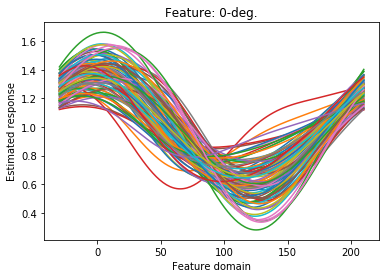

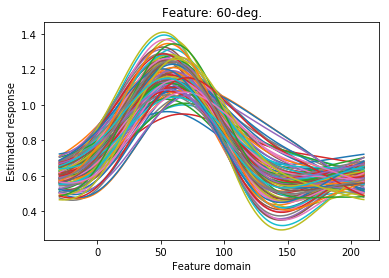

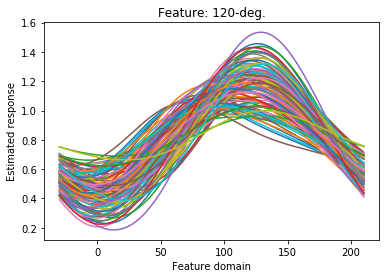

In [7]:
# Plot the estimated response from channels

plt.figure()
plt.plot(s.C_D_, y_hat_0.transpose());
plt.xlabel('Feature domain')
plt.ylabel('Estimated response')
plt.title('Feature: 0-deg.')
plt.figure()
plt.plot(s.C_D_, y_hat_60.transpose());
plt.xlabel('Feature domain')
plt.ylabel('Estimated response')
plt.title('Feature: 60-deg.')
plt.figure()
plt.plot(s.C_D_, y_hat_120.transpose());
plt.xlabel('Feature domain')
plt.ylabel('Estimated response')
plt.title('Feature: 120-deg.');

Channel responses should have peaks at the feature value corresponding to their decoded value (i.e. 0, 60, and 120).

Decoded direction of mean response: [-1, 58, 120]


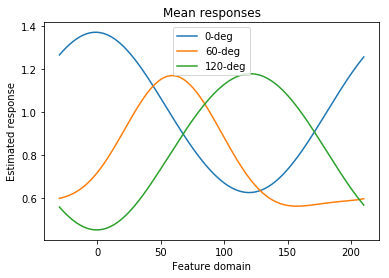

In [8]:
# Plot the average channel respone and show 
# decoded response predictions.

m0 = np.mean(y_hat_0,axis = 0)
m60 = np.mean(y_hat_60,axis = 0)
m120 = np.mean(y_hat_120,axis = 0)

plt.figure()
plt.plot(s.C_D_, m0,'-', label='0-deg')
plt.plot(s.C_D_, m60,'-', label='60-deg')
plt.plot(s.C_D_, m120,'-', label='120-deg')
plt.xlabel('Feature domain')
plt.ylabel('Estimated response')
plt.title('Mean responses')
plt.legend()

d0 = np.argmax(m0)
d60= np.argmax(m60)
d120 = np.argmax(m120)
print("Decoded direction of mean response: " + str([int(s.C_D_[d0]), int(s.C_D_[d60]), int(s.C_D_[d120])]))


Output should be the mean of the channel outputs shown in the cell above. Peaks should be evident at 0, 60, and 120, the centers of the synthetic data.

In [9]:
# Test getting parameters

param_out = s.get_params()
print(param_out)

{'n_channels': 6, 'channel_exp': 6, 'range_start': -30, 'range_stop': 210}


Output should be the parameters we initialized the object with: 6, 6, -30, 210

In [10]:
# Test setting parameters and predict again using new parameters

s.set_params(n_channels = 12, channel_exp = 7, range_start = -30, range_stop = 210)

param_out_2 = s.get_params()
print(param_out_2)

s.fit(X,y)

X3_0 = np.dot(np.random.randn(n_, dim), C) + centers_0
X3_60 = np.dot(np.random.randn(n_, dim), C) + centers_60
X3_120 = np.dot(np.random.randn(n_, dim), C) + centers_120

y3_0 = np.zeros(n_)
y3_60 = 60*np.ones(n_)
y3_120 = 120*np.ones(n_)

r_hat3_0 = s.predict(X3_0)
r_hat3_60 = s.predict(X3_60)
r_hat3_120 = s.predict(X3_120)

score_ = s.score(np.vstack((X2_0, X2_60, X2_120)), np.hstack((y2_0, y2_60, y2_120)))

print("Mean decoded direction: " + 
      str([int(np.mean(r_hat3_0)), int(np.mean(r_hat3_60)), int(np.mean(r_hat3_120))]))
print("Mean decoder performance: " + str(np.mean(score_)))

{'n_channels': 12, 'channel_exp': 7, 'range_start': -30, 'range_stop': 210}
Mean decoded direction: [7, 61, 113]
Mean decoder performance: 0.9093725227052838


We should see the parameters that we set, and decoded feature values close to the ground truth, or 0, 60, 120. Note that a change in parameter values does not change the outcome appreciably.

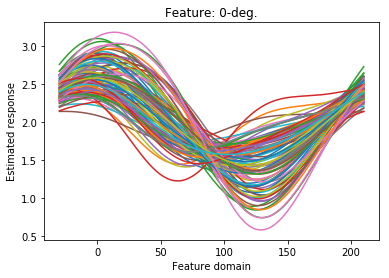

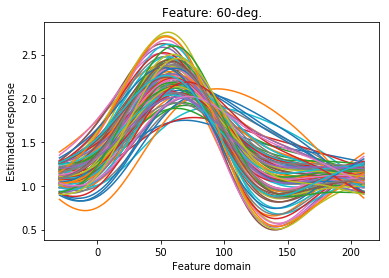

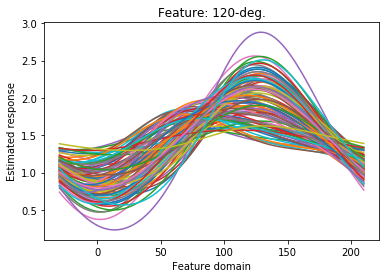

In [11]:
# Get predicted directions, like before
y_hat_0 = s._predict_directions(X2_0)
y_hat_60 = s._predict_directions(X2_60)
y_hat_120 = s._predict_directions(X2_120)

# Plot the estimated response from channels
plt.figure()
plt.plot(s.C_D_, y_hat_0.transpose());
plt.xlabel('Feature domain')
plt.ylabel('Estimated response')
plt.title('Feature: 0-deg.')
plt.figure()
plt.plot(s.C_D_, y_hat_60.transpose());
plt.xlabel('Feature domain')
plt.ylabel('Estimated response')
plt.title('Feature: 60-deg.')
plt.figure()
plt.plot(s.C_D_, y_hat_120.transpose());
plt.xlabel('Feature domain')
plt.ylabel('Estimated response')
plt.title('Feature: 120-deg.');